IMPORT LIBRARIES

In [67]:
import gzip
import numpy as np
import math
import matplotlib.pyplot as plt

# Task 1

In [75]:
train_X = gzip.open('train-images-idx3-ubyte.gz', 'r') #opening images
train_Y = gzip.open('train-labels-idx1-ubyte.gz','r') #opening labels
train_X.read(16)
train_Y.read(8)
image_dim = 28
fl_size = image_dim*image_dim #28X28 flattened vector
image_count_train = 60000 #number of samples
buffer = train_X.read(image_dim * image_dim * image_count_train)
buffer_labels = train_Y.read(1 * 60000)
data = np.frombuffer(buffer, dtype=np.uint8).astype(np.float32)
data = data.reshape(image_count_train, image_dim * image_dim) #reshaping the vector to (60000,28X28) 
labels = np.frombuffer(buffer_labels, dtype=np.uint8).astype(np.int64)

In [76]:
mean_ = np.zeros((10, fl_size))
count = np.zeros((10,1))
stdev_ = np.zeros((10, fl_size))
X = {'0':list(),'1':list(),'2':list(),'3':list(),'4':list(),'5':list(),'6':list(),'7':list(),'8':list(),'9':list()}
for index, item in enumerate(labels):
    for i in range(10):
        if item == i:
            X[str(i)].append(data[index])
            mean_[item] += data[index]
            count[item] += 1
for i in range(mean_.shape[0]):
    mean_[i] = mean_[i] / count[i] #Formula for mean
for i in range(10):
    for item in X[str(i)]:
        stdev_[i] += (item - mean_[i])**2 #Formula for standard deviation
for i in range(stdev_.shape[0]):
    stdev_[i] = np.sqrt(stdev_[i] / count[i]) #Formula for standard deviation

Mean:
    
\begin{align}
\mu = \frac{( \sum X_i)}{N}
\end{align}
            
       N - length for each class of digits.
       X - individual features of the classes.
   
   
Standard deviation:
    
\begin{align}
\sigma = \sqrt{\frac{\sum (  x_{ij} - \mu_i)}{N}}
\end{align}

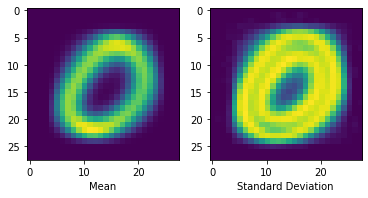

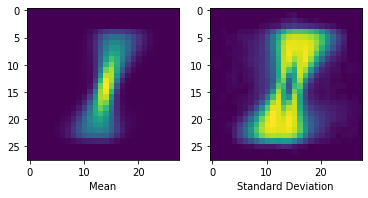

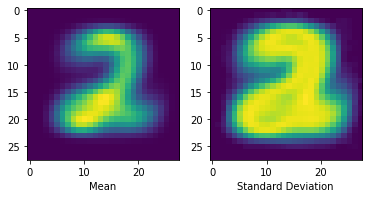

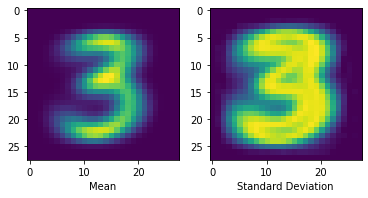

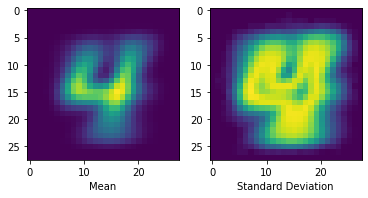

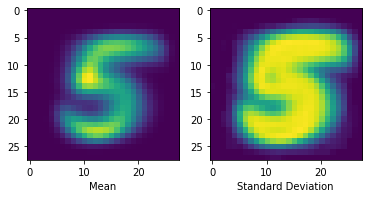

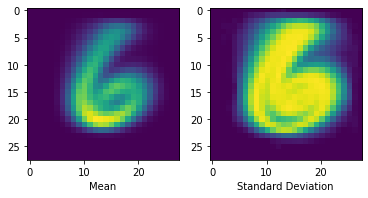

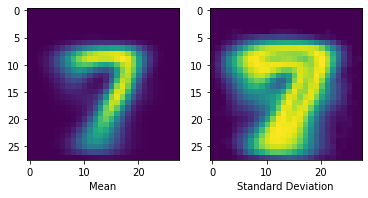

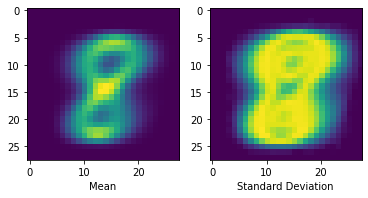

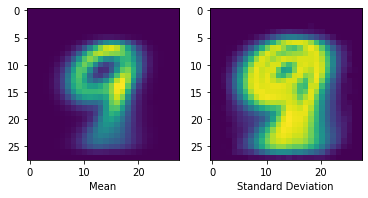

In [77]:
for i in range(0,10):
    mean = mean_[i].reshape(28,28,1).squeeze() #reshaping mean
    stdev = np.asarray(stdev_[i]).reshape(28,28,1).squeeze() #reshaping standard deviation
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(mean) #plotting mean for each digit
    plt.xlabel("Mean")
    plt.subplot(1,2,2)
    plt.imshow(stdev) #plotting standard deviation for each digit
    plt.xlabel("Standard Deviation")
    plt.show()

# Task 2

In [78]:
test_X = gzip.open('t10k-images-idx3-ubyte.gz', 'r') #opening images
test_Y = gzip.open('t10k-labels-idx1-ubyte.gz','r') #opening labels
test_X.read(16)
test_Y.read(8)
image_count_test = 10000
buffer_test = test_X.read(image_dim * image_dim * image_count_test)
buffer_test_labels = test_Y.read(1 * 10000)
data_test = np.frombuffer(buffer_test, dtype=np.uint8).astype(np.float32)
data_test = data_test.reshape(image_count_test, image_dim * image_dim)
test_labels = np.frombuffer(buffer_test_labels, dtype=np.uint8).astype(np.int64)

In [79]:
cov_digits = np.zeros((10, fl_size, fl_size)) #covariant digits 
cov_determinant = np.zeros((count.shape[0], 1)) #covariant determinant
cov_inverse = np.zeros((len(count), fl_size, fl_size)) #covariant inverse
for i in range(10):
    for image in X[str(i)]:
        temp_calc = image - mean_[i]
        temp_calc_transposed = np.transpose(temp_calc)
        cov_digits[i] = cov_digits[i] + np.dot(temp_calc_transposed, temp_calc)
for i in range(count.shape[0]):
    cov_digits[i] = np.divide(cov_digits[i], (count[i] - 1)) + 0.9 * np.eye(784)
    sign, determinant = np.linalg.slogdet(cov_digits[i])
    act_det = sign * np.exp(determinant)
    cov_determinant[i] = act_det #determinant
    inverse = np.linalg.inv(cov_digits[i])
    cov_inverse[i] = inverse #inverse 
D = fl_size
test_predict = []
#The images are classified by using Bayesian decision rule.
for index in range(len(test_labels)):
    likelihood = []   
    for i in range(10):
        temp = data_test[index] - mean_[i]      
        temp_calc = np.dot(np.dot(temp, cov_inverse[i]), np.transpose(temp))
        log_likelihood = - ( D*0.5 )*np.log( 2*math.pi ) - 0.5*cov_determinant[i] - 0.5*temp_calc
        p_c = log_likelihood + np.log(prior[i])
        likelihood.append(p_c)        
    predicted_class = np.argmax(likelihood)
    test_predict.append(predicted_class) 

This is the Gaussian distribution - LDA function
\begin{align}
p(x)=\frac{1}{(2π)^{d/2}|\sum|^{1/2}}exp(−\frac{1}{2}(x−\mu)^{′}\sum^{−1}(x−\mu))
\end{align}
 
 \begin{align}
\boldsymbol{g_{i}(x) = \log p(x|\omega_i) + \log P(\omega_i)}
\end{align}
\begin{align}
\newline = -\frac{1}{2}(x - \mu_{i})^{-1} \sum^{-1}(x - \mu_{i}) - \frac{d}{2} \log (2 \pi) -\frac{1}{2} \log |\sum_i| + \log P(\omega_i)
\end{align}

\begin{align}
\boldsymbol{g_i = x^{t} W_i x + N_{i}^{t} x + B_{i0}}
\end{align}
\begin{align}
\newline
where, W_i = - \frac{1}{2} \sum_{i}^{-1} , N_{i} = \sum_{i}^{-1} \mu_{i} and B_{i0} = - \frac{1}{2} \mu_{i}^{t} \sum_{i}^{-1} \mu_{i} + ln P(w_i) - \frac{1}{2} ln |\sum_{i}| 
\end{align}

In [82]:
def acc(pred, actual):
    c = 0
    loss = []
    for i in range(len(pred)):
        if pred[i] == actual[i]:
            c += 1
            loss.append(0)
        else:
            loss.append(1)
    acc = (1 - sum(loss)/len(pred)) * 100
    return acc

In [83]:
accuracy = acc(test_predict, test_labels)
print ("Accuracy of Bayes Decision Rule is", accuracy, "%")

Accuracy of Bayes Decision Rule is 82.49 %


# Why it doesn’t perform as good as many other methods on LeCun’s web page?

1. The distribution of the feature vectors in this function are in Gaussian Distribution, and it doesn't perform good on high dimensional data images. 
2. The Discriminant analysis predicts based on the similarities of 'mean' and 'Standard deviation' of the images, and doesn't rely on the individual features.
3. LDA maximizes the variances in the hyperplane, which is not optimal. Usually it finds a hyperplane to disjoin the labelled dataset.